<a href="https://colab.research.google.com/github/Boldcodes/Wheat_Detection_YOLOv5/blob/main/Global_Wheat_Detection_Using_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Relevant Libraries

In [1]:
import torch
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2

## Clone YOLOv5 GitHub repository

Clone the YOLOv5 repository, and move all the yolo files to this current working directory

In [2]:
!git clone https://github.com/ultralytics/yolov5 
!mv yolov5/* ./

Cloning into 'yolov5'...
remote: Enumerating objects: 15123, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 15123 (delta 42), reused 31 (delta 11), pack-reused 15045
Receiving objects: 100% (15123/15123), 14.13 MiB | 14.79 MiB/s, done.
Resolving deltas: 100% (10359/10359), done.


In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.2.0 which is incompatible.


## Kaggle API


Go to your Kaggle>Account>API and click on “Create New API Token”, a kaggle.json file will be downloaded. Upload it after running the code snippet below.

In [4]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"boldcodes","key":"0463b0cf5117473ab3fb96ce37046287"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/



In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets list 

ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset               Hotel Reservations Dataset                         480KB  2023-01-04 12:50:31          10627        344  1.0              
googleai/musiccaps                                              MusicCaps                                          793KB  2023-01-25 09:25:48           2365        209  0.9411765        
themrityunjaypathak/most-subscribed-1000-youtube-channels       Most Subscribed 1000 Youtube Channels               28KB  2023-01-21 14:42:05           3356         97  1.0              
nitishsharma01/olympics-124-years-datasettill-2020              O

### Download the Data

Download the Global Wheat Detection Dataset

In [8]:
! kaggle competitions download -c global-wheat-detection

100% 606M/607M [00:28<00:00, 23.1MB/s]
100% 607M/607M [00:29<00:00, 21.9MB/s]


## Data Preparation & Modeling

### Unzip Data

Unzip the global-wheat-detection.zip file and save the files in the directory wheat_data

In [9]:
!unzip global-wheat-detection.zip -d wheat_data

Archive:  global-wheat-detection.zip
  inflating: wheat_data/sample_submission.csv  
  inflating: wheat_data/test/2fd875eaa.jpg  
  inflating: wheat_data/test/348a992bb.jpg  
  inflating: wheat_data/test/51b3e36ab.jpg  
  inflating: wheat_data/test/51f1be19e.jpg  
  inflating: wheat_data/test/53f253011.jpg  
  inflating: wheat_data/test/796707dd7.jpg  
  inflating: wheat_data/test/aac893a91.jpg  
  inflating: wheat_data/test/cb8d261a3.jpg  
  inflating: wheat_data/test/cc3532ff6.jpg  
  inflating: wheat_data/test/f5a1f0358.jpg  
  inflating: wheat_data/train.csv    
  inflating: wheat_data/train/00333207f.jpg  
  inflating: wheat_data/train/005b0d8bb.jpg  
  inflating: wheat_data/train/006a994f7.jpg  
  inflating: wheat_data/train/00764ad5d.jpg  
  inflating: wheat_data/train/00b5c6764.jpg  
  inflating: wheat_data/train/00b5fefed.jpg  
  inflating: wheat_data/train/00b70a919.jpg  
  inflating: wheat_data/train/00e903abe.jpg  
  inflating: wheat_data/train/00ea5e5ee.jpg  
  inflating: 

## Bounding Boxes

yolo expects a .txt file for every image that contains the following info about the bounding box:

‘classes’,’x_center’,’y_center’,’w’,’h’

Here x_center and y_center correspond to the center of the bounding box, and w and h correspond to the width and height of the bounding box.

In [10]:
df = pd.read_csv('/content/wheat_data/train.csv')
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))

for i, column in enumerate(['x','y','w','h']):
  df[column] = bboxs[:,i]

df.drop(columns=['bbox'], inplace=True)
df['x_center'] = df['x'] + df['w']/2
df['y_center'] = df['y'] + df['h']/2
df['classes'] = 0

from tqdm.auto import tqdm
import shutil as sh
df = df[['image_id','x','y','w','h','x_center','y_center','classes']]

Let's get a glimpse of the dataset

In [11]:
df.head()

image_id      x      y      w      h  x_center  y_center  classes
0  b6ab77fd7  834.0  222.0   56.0   36.0     862.0     240.0        0
1  b6ab77fd7  226.0  548.0  130.0   58.0     291.0     577.0        0
2  b6ab77fd7  377.0  504.0   74.0  160.0     414.0     584.0        0
3  b6ab77fd7  834.0   95.0  109.0  107.0     888.5     148.5        0
4  b6ab77fd7   26.0  144.0  124.0  117.0      88.0     202.5        0

## Data Preparation for YOLOv5


YOLO expects data to be divided into train and validation folders, where each folder contains two subfolders, one subfolder containing the images and the other subfolder containing a .txt file that includes the bounding box of each of the images.

Let’s create a convertor folder that contains training (named “train2017” here) and a validation folder(named “val2017”)

In [12]:
index = list(set(df.image_id))
len(index)

source = 'train'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('convertor/fold{}/labels/'.format(fold)+path2save)
            with open('convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row/1024
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/wheat_data/{}/{}.jpg".format(source,name),'convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

  0%|          | 0/3373 [00:00<?, ?it/s]

## Configuration Files


For a yolo model, we need two config files with .yaml as extension; one contains the location of training & validation folders, the number of classes, and class names, second YAML file contains yolo model architecture.

## First YAML File

In [13]:
%%writefile ./convertor/wheat0.yaml

# COCO 2017 dataset http://cocodataset.org - first 128 training images
# Download command:  python -c "from yolov5.utils.google_utils import gdrive_download; gdrive_download('1n_oKgR81BJtqk75b00eAjdv03qVCQn2f','coco128.zip')"
# Train command: python train.py --data ./data/coco128.yaml
# Dataset should be placed next to yolov5 folder:
#   /parent_folder
#     /coco128
#     /yolov5


# train and val datasets (image directory or *.txt file with image paths)
train: ./convertor/fold0/images/train2017/
val: ./convertor/fold0/images/val2017/

# number of classes
nc: 1

# class names
names: ['wheat']

Writing ./convertor/wheat0.yaml


## Second YAML File

In [14]:
%%writefile ./convertor/yolov5x.yaml



# parameters
nc: 1  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# parameters
nc: 1  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# anchors
anchors:
  - [116,90, 156,198, 373,326]  # P5/32
  - [30,61, 62,45, 59,119]  # P4/16
  - [10,13, 16,30, 33,23]  # P3/8

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
  ]

# YOLOv5 head
head:
  [[-1, 3, BottleneckCSP, [1024, False]],  # 9

   [-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1]],  # 18 (P3/8-small)

   [-2, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1]],  # 22 (P4/16-medium)

   [-2, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1]],  # 26 (P5/32-large)

   [[], 1, Detect, [nc, anchors]],  # Detect(P5, P4, P3)
  ]

Writing ./convertor/yolov5x.yaml


## Model Training

In [15]:
!python /content/train.py --img 1024 --batch 16 --epochs 15 --data /content/convertor/wheat0.yaml --name yolov5x_fold0 

train: weights=yolov5s.pt, cfg=, data=/content/convertor/wheat0.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5x_fold0, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2023-2-11 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anch

In [16]:
 # get a lis of experiments

 exp_list = os.listdir('/content/runs/train')

 # Get the latest exp

 exp = exp_list[-1]

 exp

'yolov5x_fold0'

## Model Visualization

In [17]:
!python /content/detect.py --weights runs/train/yolov5x_fold0/weights/best.pt --img 1024  --source /content/convertor/fold0/images/val2017

detect: weights=['runs/train/yolov5x_fold0/weights/best.pt'], source=/content/convertor/fold0/images/val2017, data=data/coco128.yaml, imgsz=[1024, 1024], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2023-2-11 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/674 /content/convertor/fold0/images/val2017/013fd7d80.jpg: 1024x1024 50 wheats, 23.3ms
image 2/674 /content/convertor/fold0/images/val2017/02f0fe2ca.jpg: 1024x1024 21 wheats, 23.4ms
image 3/674 /content/convertor/fold0/images/val2017/034090252.jpg: 1024x1024 47 wheats, 23.3ms
image 4/674 /content/convertor/fold0/

In [18]:
# Display the contents of the 'exp' folder

os.listdir(f'/content/runs/train/{exp}')

['train_batch1.jpg',
 'R_curve.png',
 'labels.jpg',
 'val_batch1_labels.jpg',
 'val_batch2_labels.jpg',
 'weights',
 'train_batch0.jpg',
 'opt.yaml',
 'val_batch0_labels.jpg',
 'confusion_matrix.png',
 'P_curve.png',
 'results.csv',
 'val_batch1_pred.jpg',
 'results.png',
 'val_batch0_pred.jpg',
 'hyp.yaml',
 'labels_correlogram.jpg',
 'val_batch2_pred.jpg',
 'events.out.tfevents.1676137374.8e28004adb81.744.0',
 'PR_curve.png',
 'train_batch2.jpg',
 'F1_curve.png']

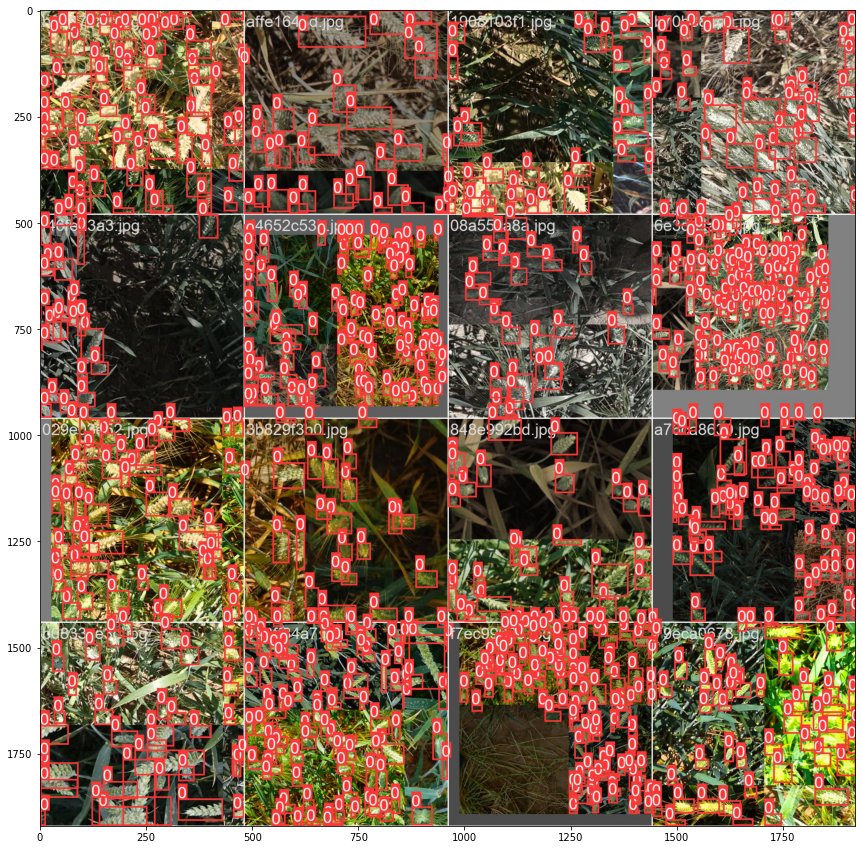

In [20]:
# One mosaic batch of train images with labels

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/train_batch0.jpg'))

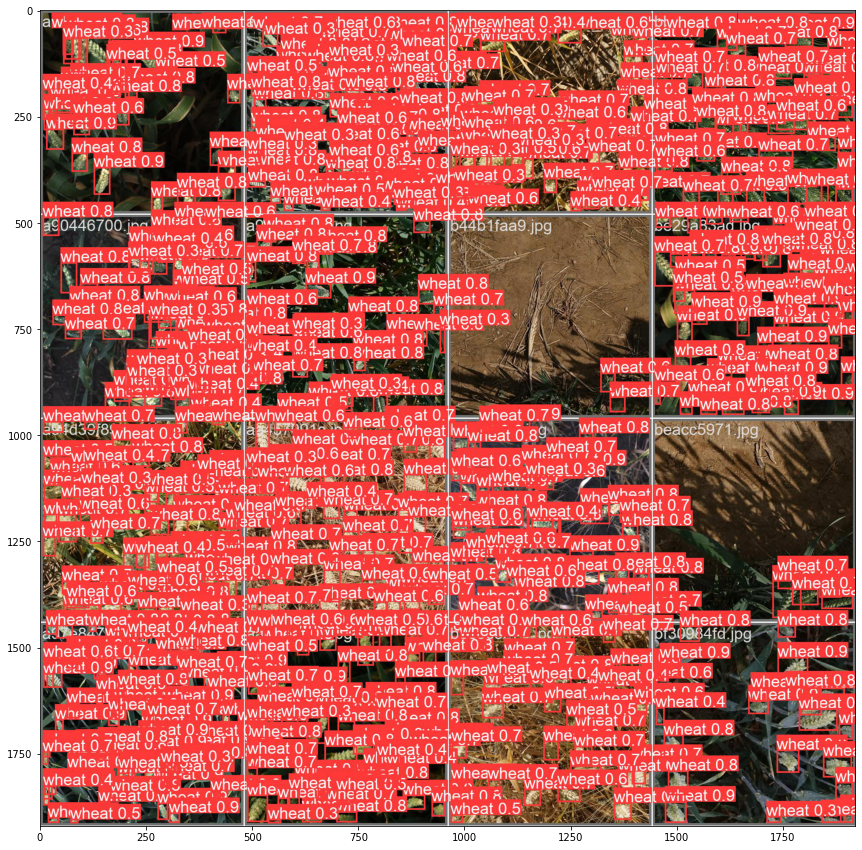

In [19]:
# One batch of val images with true labels

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{exp}/val_batch1_pred.jpg'))

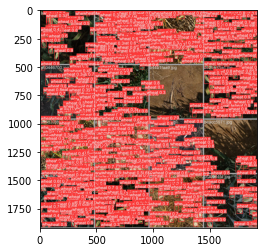

In [21]:
plt.imshow(plt.imread(f'runs/train/{exp}/val_batch1_pred.jpg'))

The image above, which is a collection of validation photographs, could appear disorganized. The model draws bounding boxes with a confidence score around each head of wheat in each image.